# future_emis
## Purpose: input IAM projections of future emissions under different policy scenarios
- Data from NGFS

### 01/29/24, Erica Simon

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import copy

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [19]:
df_emis = pd.read_csv('~/inputs/all_scaled_1750-2022.csv')

# remove 'Emissions|' from variable name
for i in range(len(df_emis.variable.values)): 
    df_emis.variable.values[i] = df_emis.variable.values[i][10:]

# rename to match FaIR spceies
df_emis.loc[df_emis.variable == 'CO2|AFOLU', 'variable'] = 'CO2 AFOLU'
df_emis.loc[df_emis.variable == 'CO2|Energy and Industrial Processes', 'variable'] = 'CO2 FFI'

df_emis.head()

,model,scenario,region,variable,unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Historical,GCP+CEDS+PRIMAP+GFED,World,BC,Mt BC/yr,2.096766,2.071972,2.067178,2.070382,2.098586,...,7.842259,7.934828,7.926371,7.568060,7.562319,7.459095,7.781842,6.525021,6.871947,6.701702
1,Historical,GCP+CEDS+PRIMAP+GFED,World,C2F6,kt C2F6/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.003458,1.035565,0.933936,0.979945,0.996980,0.996764,1.062577,1.106550,1.160588,1.167145
2,Historical,GCP+CEDS+PRIMAP+GFED,World,C3F8,kt C3F8/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.314138,0.323186,0.304124,0.319107,0.324656,0.324586,0.346019,0.360340,0.377938,0.380074
3,Historical,GCP+CEDS+PRIMAP+GFED,World,C4F10,kt C4F10/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070672,0.070641,0.067024,0.070327,0.071550,0.071536,0.076260,0.079417,0.083292,0.083759
4,Historical,GCP+CEDS+PRIMAP+GFED,World,C5F12,kt C5F12/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035588,0.031141,0.030030,0.031513,0.032065,0.032062,0.034184,0.035603,0.037338,0.037545


# The Global Methane Pledge
pledge to reduce global methane emissions **at least 30 percent** from 2020 levels by 2030

In [116]:
df_emis.loc[df_emis.variable == 'CH4']['2020'].values[0]

374.8219357769454

In [135]:
ch4_df = copy.copy(df_emis.loc[df_emis.variable == 'CH4'])

new_value = df_emis.loc[df_emis.variable == 'CH4']['2020'].values[0]

for i in range(2021, 2101):
    ch4_df[str(i)] = new_value

for val in [30, 40, 50]:
    perc = val * 0.01
    
    row_to_duplicate = ch4_df.loc[ch4_df.variable == 'CH4']
    row_to_duplicate['variable'] = 'CH4_{}'.format(val)
    ch4_df = ch4_df.append(row_to_duplicate, ignore_index=True)
    
    for i in range(2021, 2101):
        ch4_df.loc[ch4_df.variable == 'CH4_{}'.format(val), str(i)] = ch4_df.loc[ch4_df.variable == 'CH4', str(i)][0] * (1 - val * 0.01)
    
ch4_df

/tmp/ipykernel_27338/1205358283.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ch4_df = ch4_df.append(row_to_duplicate, ignore_index=True)
/tmp/ipykernel_27338/1205358283.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_to_duplicate['variable'] = 'CH4_{}'.format(val)


,model,scenario,region,variable,unit,1750,1751,1752,1753,1754,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Historical,GCP+CEDS+PRIMAP+GFED,World,CH4,Mt CH4/yr,38.246272,38.106144,38.070994,38.237775,38.585534,...,374.821936,374.821936,374.821936,374.821936,374.821936,374.821936,374.821936,374.821936,374.821936,374.821936
1,Historical,GCP+CEDS+PRIMAP+GFED,World,CH4_30,Mt CH4/yr,38.246272,38.106144,38.070994,38.237775,38.585534,...,262.375355,262.375355,262.375355,262.375355,262.375355,262.375355,262.375355,262.375355,262.375355,262.375355
2,Historical,GCP+CEDS+PRIMAP+GFED,World,CH4_40,Mt CH4/yr,38.246272,38.106144,38.070994,38.237775,38.585534,...,224.893161,224.893161,224.893161,224.893161,224.893161,224.893161,224.893161,224.893161,224.893161,224.893161
3,Historical,GCP+CEDS+PRIMAP+GFED,World,CH4_50,Mt CH4/yr,38.246272,38.106144,38.070994,38.237775,38.585534,...,187.410968,187.410968,187.410968,187.410968,187.410968,187.410968,187.410968,187.410968,187.410968,187.410968


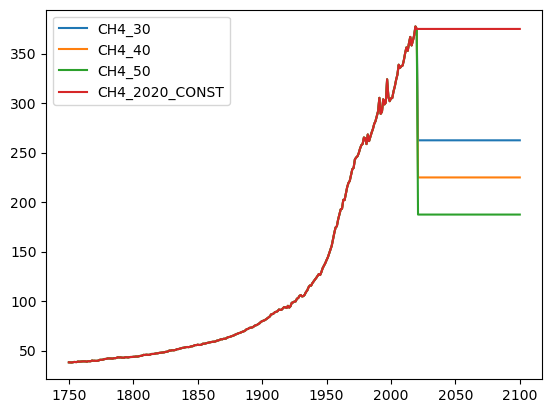

In [136]:
plt.plot(np.arange(1750, 2101), ch4_df.loc[ch4_df.variable == 'CH4_30'].values[0][5:], label='CH4_30')
plt.plot(np.arange(1750, 2101), ch4_df.loc[ch4_df.variable == 'CH4_40'].values[0][5:], label='CH4_40')
plt.plot(np.arange(1750, 2101), ch4_df.loc[ch4_df.variable == 'CH4_50'].values[0][5:], label='CH4_50')
plt.plot(np.arange(1750, 2101), ch4_df.loc[ch4_df.variable == 'CH4'].values[0][5:], label='CH4_2020_CONST')
plt.legend()